# Figure 5: Learning curves at m=128 (softmax)

Combined 2x2 grid: (a) MNIST test, (b) CIFAR-10 test, (c) MNIST train, (d) CIFAR-10 train. Baseline ViT is bold; other curves follow Figure 3 colors/styles with kernel fixed to softmax.


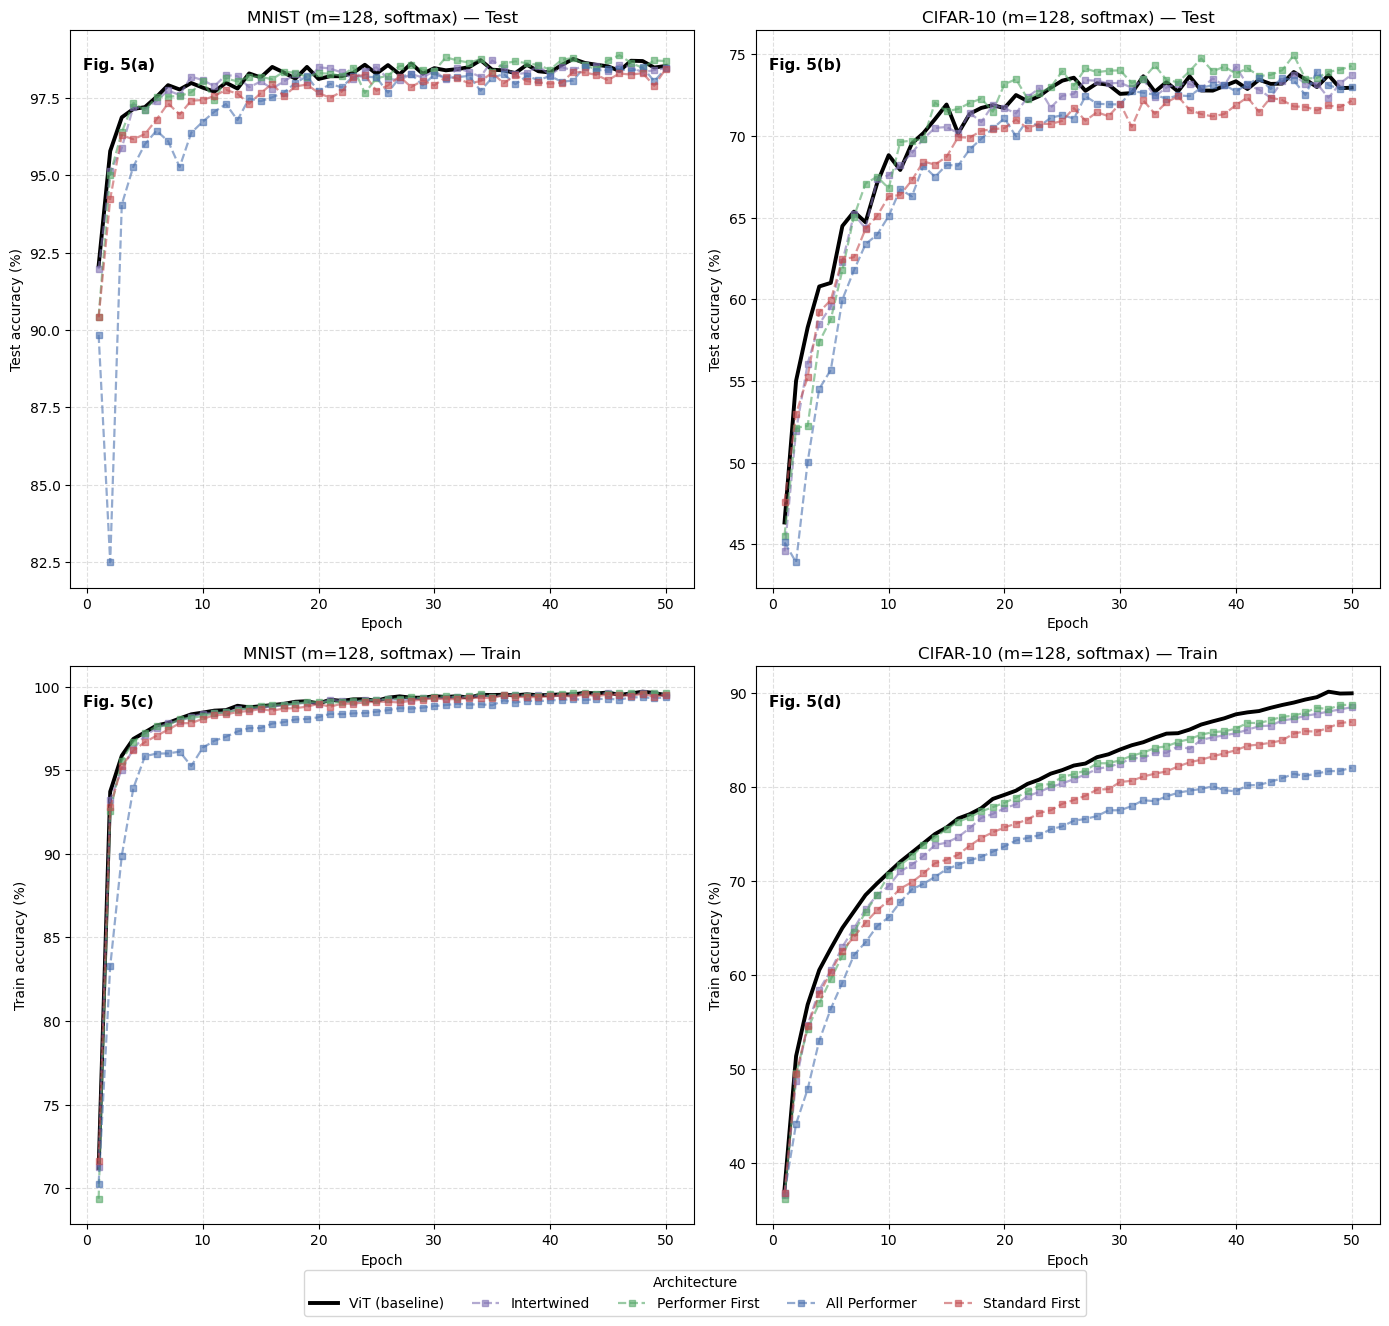

In [7]:
from pathlib import Path
import re

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

m_target = 128
arch_order = [
    ("all_performer", "All Performer"),
    ("performer_first", "Performer First"),
    ("standard_first", "Standard First"),
    ("intertwined", "Intertwined"),
]
arch_label = {k: v for k, v in arch_order}

kernels = ["softmax"]
colors = {
    "all_performer": "#4c72b0",
    "performer_first": "#55a868",
    "standard_first": "#c44e52",
    "intertwined": "#8172b3",
}
linestyles = {"relu": "-", "softmax": "--"}
markers = {"relu": "o", "softmax": "s"}
marker_size = 4
alpha_nonbaseline = 0.6

summary_re = re.compile(r"summary_arch-(?P<arch>.+?)_kernel-(?P<kernel>.+?)_m-(?P<m>[^.]+)")


def load_curve(history_path: Path, col: str):
    df = pd.read_csv(history_path)
    if df.empty or "epoch" not in df.columns or col not in df.columns:
        return None
    return df["epoch"].tolist(), df[col].tolist()


def collect_curves(dataset: str, metric_col: str):
    curves = []
    base_hist = results_dir / dataset / "history_baseline.csv"
    if base_hist.exists():
        base_data = load_curve(base_hist, metric_col)
        if base_data:
            curves.append({
                "label": "ViT (baseline)",
                "color": "#000000",
                "linestyle": "-",
                "marker": None,
                "linewidth": 2.8,
                "markersize": marker_size,
                "alpha": 1.0,
                "epochs": base_data[0],
                "values": base_data[1],
            })

    pattern = f"{dataset}/summary_arch-*_kernel-*_m-*.csv"
    for summary_path in results_dir.glob(pattern):
        match = summary_re.match(summary_path.name)
        if not match:
            continue
        arch = match.group("arch")
        kernel = match.group("kernel")
        try:
            m = float(match.group("m"))
        except ValueError:
            continue
        if m != m_target:
            continue
        if arch not in arch_label or kernel not in kernels:
            continue

        history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
        if not history_path.exists():
            continue
        data = load_curve(history_path, metric_col)
        if not data:
            continue
        curves.append({
            "label": arch_label[arch],
            "color": colors.get(arch),
            "linestyle": linestyles[kernel],
            "marker": markers[kernel],
            "linewidth": 1.6,
            "markersize": marker_size,
            "alpha": alpha_nonbaseline,
            "epochs": data[0],
            "values": data[1],
        })
    return curves


def plot_panel(ax, dataset: str, metric_col: str, title: str, ylabel: str):
    curves = collect_curves(dataset, metric_col)
    if not curves:
        raise ValueError(f"No curves found for {dataset} at m={m_target}")

    for c in curves:
        ax.plot(
            c["epochs"],
            c["values"],
            label=c["label"],
            color=c["color"],
            linestyle=c["linestyle"],
            marker=c["marker"],
            linewidth=c["linewidth"],
            markersize=c["markersize"],
            alpha=c["alpha"],
        )

    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)


fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=False, sharey=False)

labels_grid = [["Fig. 5(a)", "Fig. 5(b)"], ["Fig. 5(c)", "Fig. 5(d)"]]

plot_panel(axes[0, 0], "MNIST", "test_acc", "MNIST (m=128, softmax) — Test", "Test accuracy (%)")
plot_panel(axes[0, 1], "CIFAR10", "test_acc", "CIFAR-10 (m=128, softmax) — Test", "Test accuracy (%)")
plot_panel(axes[1, 0], "MNIST", "train_acc", "MNIST (m=128, softmax) — Train", "Train accuracy (%)")
plot_panel(axes[1, 1], "CIFAR10", "train_acc", "CIFAR-10 (m=128, softmax) — Train", "Train accuracy (%)")

# Add subplot labels
for r in range(2):
    for c in range(2):
        axes[r, c].text(
            0.02,
            0.95,
            labels_grid[r][c],
            transform=axes[r, c].transAxes,
            fontsize=11,
            fontweight="bold",
            va="top",
            ha="left",
        )

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Architecture", loc="lower center", ncol=5, bbox_to_anchor=(0.5, 0.0511))
plt.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()
